In [20]:
import pandas as pd
from prophet import Prophet

# Read pandas dataframe
df = pd.read_csv('gas_demand_test.csv')

# Inspect data
display(df.shape)
display(df.head())
display(df.dtypes)
display(df.isnull().any())

(206, 2)

,TIME,European Union - 27 countries (from 2020)
0,2008-01,2012060
1,2008-02,1754306
2,2008-03,1736092
3,2008-04,1372621
4,2008-05,1041214


TIME                                         object
European Union - 27 countries (from 2020)    object
dtype: object

TIME                                         False
European Union - 27 countries (from 2020)    False
dtype: bool

In [21]:
# Rename columns
df = df.rename(columns = {'TIME':'ds', 'European Union - 27 countries (from 2020)': 'y'})


# Front-fill missing data
df['y'] = df['y'].replace(':', None)
df['y'] = pd.to_numeric(df['y'])
df['y'] = df['y'].ffill()

# Timestamp conversion
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp('M')
df

,ds,y
0,2008-01-31,2012060.000
1,2008-02-29,1754306.000
2,2008-03-31,1736092.000
3,2008-04-30,1372621.000
4,2008-05-31,1041214.000
...,...,...
201,2024-10-31,940354.976
202,2024-11-30,1417925.066
203,2024-12-31,1643133.040
204,2025-01-31,1741001.241


In [22]:
# Instantiate a Prophet object
m = Prophet(
    #changepoint_prior_scale= change regularisation effect of changepoints, increasing the scale increases the forecast uncertainty (more historical changepoints, more changepoints expected in forecast)
    #changepoints= specify specific change points
    #holidays= model holidays
    #yearly_seasonality= change sensitivity of seasonality
    #holidays_prior_scale= change regularisation effect of holidays
    #seasonality_prior_scale= change regularisation effects of seasonality
    #seasonality_mode= set seasonality as additive or multiplicative
)

# m.add_regressor = add a new regressor e.g. a binary indicator, or another time series (future values must be known)
# m.add_seasonality = add a seasonal component

#df['cap'] = 7
#df['floor'] = 0.7

# Fit dataframe into model
m.fit(df)

#Set future periods for prediction 
future = m.make_future_dataframe(24, 'ME') 

#Set maximum capacity
#future['cap'] = 7
#future['floor'] = 0.7


future.tail()

15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:46 - cmdstanpy - INFO - Chain [1] done processing


,ds
225,2026-10-31
226,2026-11-30
227,2026-12-31
228,2027-01-31
229,2027-02-28


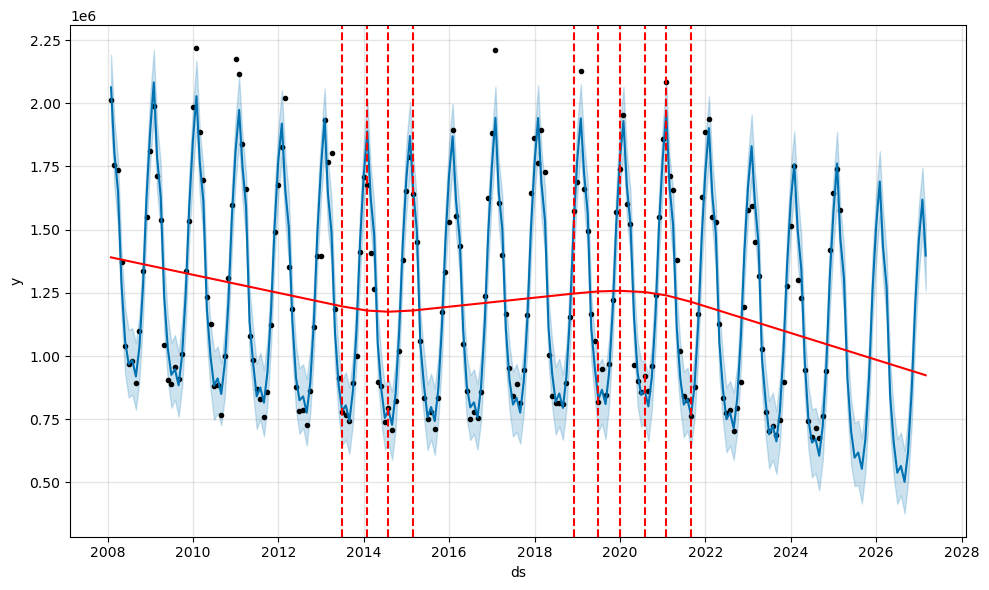

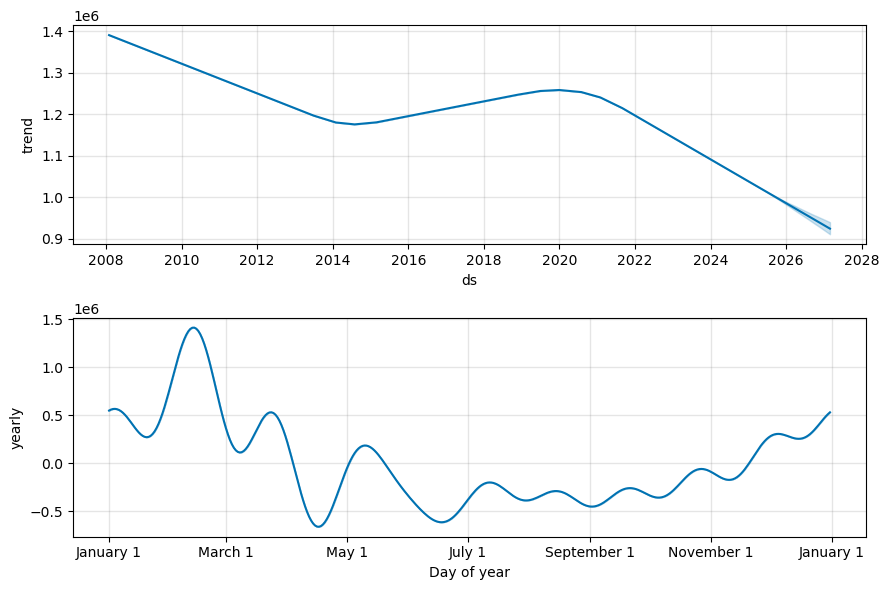

In [23]:
#Make predictions for future dates
from prophet.plot import add_changepoints_to_plot

forecast = m.predict(future)
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [24]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
225,2026-10-31,941247.875652,7.265637e+05,9.974036e+05,931131.278311,953070.810357,-79288.878158,-79288.878158,-79288.878158,-79288.878158,-79288.878158,-79288.878158,0.0,0.0,0.0,8.619590e+05
226,2026-11-30,936906.566646,1.068839e+06,1.329786e+06,926061.798084,949706.150893,262623.849092,262623.849092,262623.849092,262623.849092,262623.849092,262623.849092,0.0,0.0,0.0,1.199530e+06
227,2026-12-31,932420.547340,1.324097e+06,1.592051e+06,920651.066714,946218.418752,524175.894737,524175.894737,524175.894737,524175.894737,524175.894737,524175.894737,0.0,0.0,0.0,1.456596e+06
228,2027-01-31,927934.528033,1.490735e+06,1.744521e+06,915312.063732,942725.776156,691048.783870,691048.783870,691048.783870,691048.783870,691048.783870,691048.783870,0.0,0.0,0.0,1.618983e+06
229,2027-02-28,923882.639627,1.259072e+06,1.527018e+06,910354.769883,939489.654010,473593.702433,473593.702433,473593.702433,473593.702433,473593.702433,473593.702433,0.0,0.0,0.0,1.397476e+06


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

y_true = df['y'].values
y_pred = forecast['yhat'][:206].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)

mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.2f' % mape)

mse = mean_squared_error(y_true, y_pred)
print('MSE: %.2f' %mse)

r2 = r2_score(y_true, y_pred)
print('r2: %.2f' % r2)

MAE: 74140.20
MAPE: 0.06
MSE: 10266198006.57
r2: 0.94


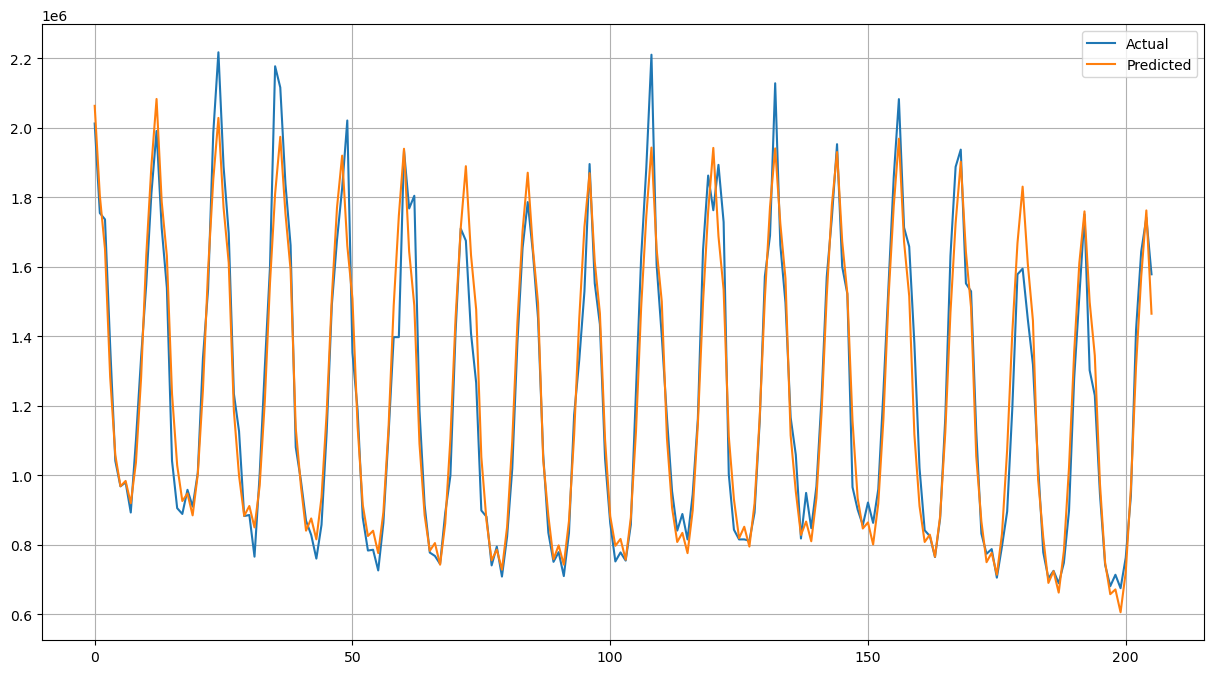

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.grid(True)
plt.legend()
plt.show()


In [27]:
import optuna

def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10, log=True),
    }
    
    m = Prophet(**params).add_country_holidays(country_name='SG')
    m.fit(df)
    forecast = m.predict(future)
    
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape


     

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_params)
print(study.best_value)

[I 2025-05-04 15:10:47,150] A new study created in memory with name: no-name-166d433c-2201-40eb-9655-b62cc7585063
15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-04 15:10:47,505] Trial 0 finished with value: 0.057052051102006646 and parameters: {'changepoint_prior_scale': 0.18569072517375054, 'changepoint_range': 0.8265042867930051, 'seasonality_prior_scale': 2.1604624786589035, 'holidays_prior_scale': 0.8295937207236863}. Best is trial 0 with value: 0.057052051102006646.
15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-04 15:10:47,778] Trial 1 finished with value: 0.057052051102006646 and parameters: {'changepoint_prior_scale': 0.03860446003201046, 'changepoint_range': 0.8204001863300487, 'seasonality_prior_scale': 0.33099072576188493, 'holidays_prior_scale': 4.97794261425412}. Best is trial 0 with value: 0.057052051102006646.
15:10:47 

{'changepoint_prior_scale': 0.18569072517375054, 'changepoint_range': 0.8265042867930051, 'seasonality_prior_scale': 2.1604624786589035, 'holidays_prior_scale': 0.8295937207236863}
0.057052051102006646


15:12:01 - cmdstanpy - INFO - Chain [1] start processing
15:12:01 - cmdstanpy - INFO - Chain [1] done processing
15:12:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:12:01 - cmdstanpy - INFO - Chain [1] start processing
15:12:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 95641.30
MAPE: 0.08
MSE: 14542208193.86
r2: 0.92


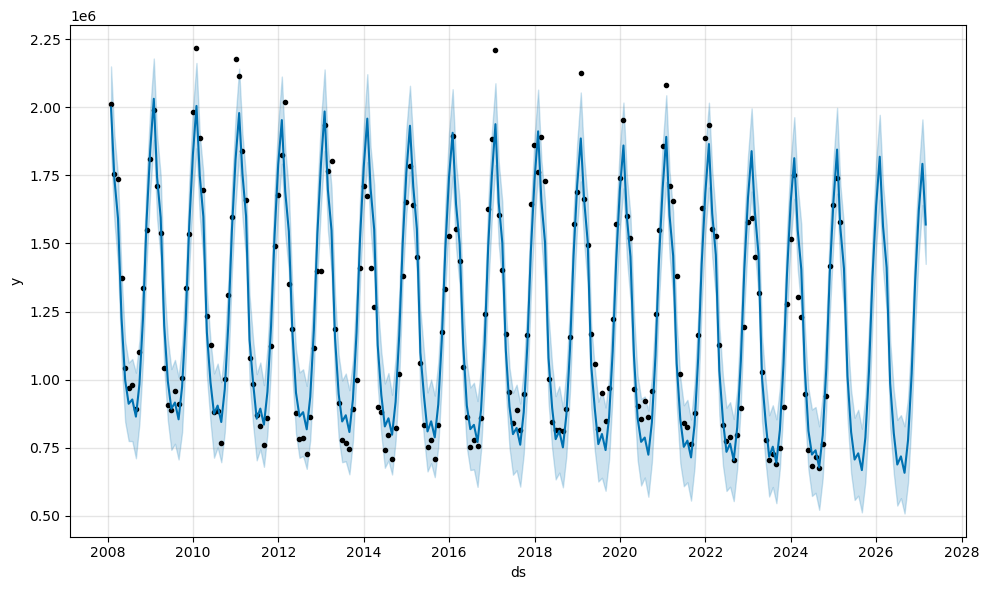

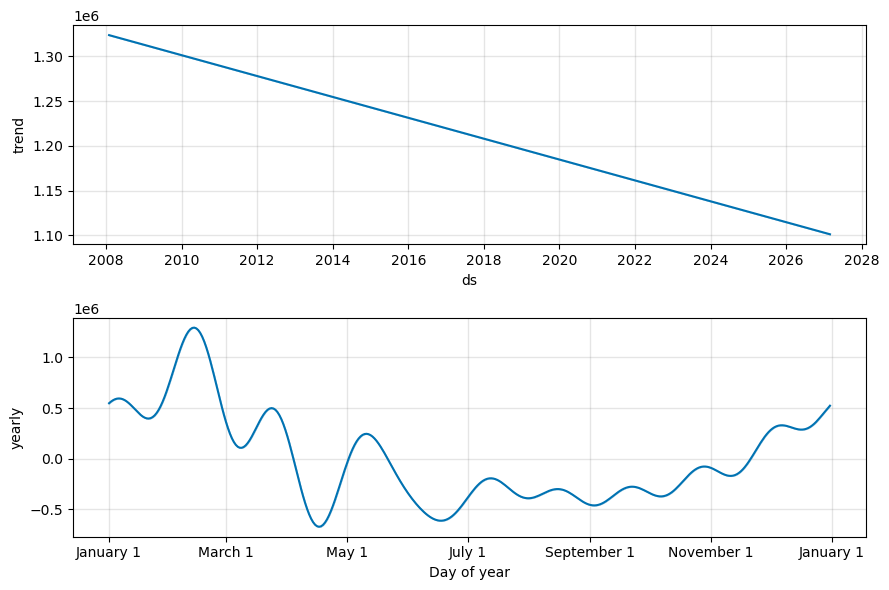

In [29]:
best_params = {'changepoint_prior_scale': 0.0034465175431684855, 'changepoint_range': 0.8039318725974123, 'seasonality_prior_scale': 9.631800860671829}


m_best = Prophet(**best_params).fit(df)
future = m_best.make_future_dataframe(24, 'ME') 



forecast_best = m_best.predict(future)
fig1 = m_best.plot(forecast_best)
fig2 = m_best.plot_components(forecast_best)


y_true = df['y'].values
y_best = forecast_best['yhat'][:206].values

mae = mean_absolute_error(y_true, y_best)
print('MAE: %.2f' % mae)

mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)

mse = mean_squared_error(y_true, y_best)
print('MSE: %.2f' %mse)

r2 = r2_score(y_true, y_best)
print('r2: %.2f' % r2)